In [ ]:
!pip install qiskit qiskit-aer
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import partial_trace, Statevector, entropy

--- Simulating 12-Qubit Evaporation ---
Step 1: B size = 11, R size = 1, S_vN = 0.0000
Step 2: B size = 10, R size = 2, S_vN = 0.9997
Step 3: B size = 9, R size = 3, S_vN = 1.9959
Step 4: B size = 8, R size = 4, S_vN = 2.9799
Step 5: B size = 7, R size = 5, S_vN = 3.9085
Step 6: B size = 6, R size = 6, S_vN = 4.6236
Step 7: B size = 5, R size = 7, S_vN = 4.6383
Step 8: B size = 4, R size = 8, S_vN = 3.9232
Step 9: B size = 3, R size = 9, S_vN = 2.9774
Step 10: B size = 2, R size = 10, S_vN = 1.9935
Step 11: B size = 1, R size = 11, S_vN = 0.9971


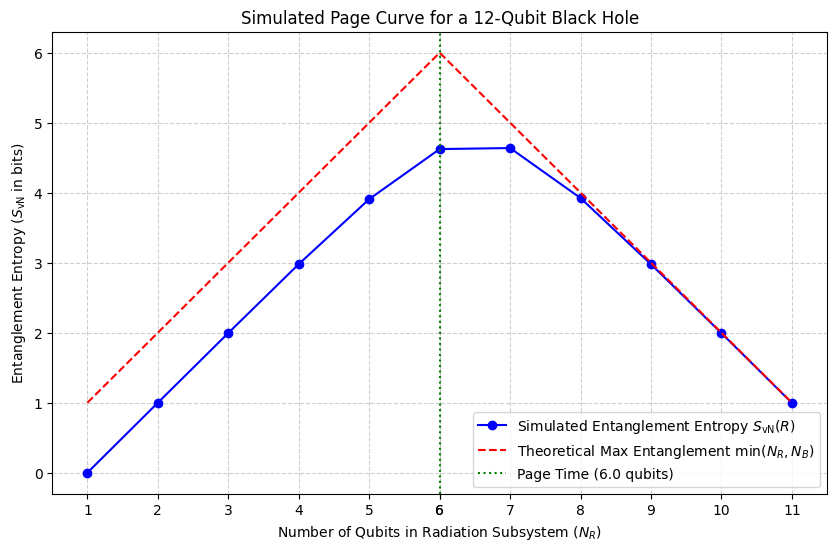

In [ ]:
# --- 1. System Definition Parameters ---
N_QUBITS = 12  # Total number of degrees of freedom (qubits)
B_INITIAL_SIZE = N_QUBITS # Initial size of the Black Hole (B) subsystem
R_INITIAL_SIZE = 0        # Initial size of the Radiation (R) subsystem

# Import necessary libraries within this cell
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import partial_trace, Statevector, entropy


# --- 2. Evaporation Operation (Unitary) ---
def get_scrambling_unitary(b_qubits_indices, num_total_qubits):
    """
    Creates a more complex entangling unitary gate across the current black hole
    qubits to model entanglement and scrambling. Increased complexity.
    """
    qc = QuantumCircuit(num_total_qubits)
    # Apply multiple layers of diverse entangling gates and local rotations for more scrambling
    for _ in range(15): # Keeping layers at 15 but increasing complexity per layer
        # Apply a mix of CNOT, CZ, and CY gates in different patterns
        if len(b_qubits_indices) > 1:
            for i in range(len(b_qubits_indices) - 1):
                qc.cx(b_qubits_indices[i], b_qubits_indices[i+1])
                qc.cz(b_qubits_indices[i], b_qubits_indices[i+1])
                qc.cy(b_qubits_indices[i+1], b_qubits_indices[i]) # Varying target/control
                qc.swap(b_qubits_indices[i], b_qubits_indices[i+1]) # Add SWAP gates

        # Apply local rotations with varying angles
        for qubit_index in b_qubits_indices:
            qc.rz(np.random.rand() * 2 * np.pi, qubit_index)
            qc.ry(np.random.rand() * 2 * np.pi, qubit_index)
            qc.rx(np.random.rand() * 2 * np.pi, qubit_index)

        # Add global entangling gates between more distant qubits
        if len(b_qubits_indices) > 3:
             # Example: CNOT between the first and last, and second and second-to-last
            qc.cx(b_qubits_indices[0], b_qubits_indices[-1])
            qc.cy(b_qubits_indices[1], b_qubits_indices[-2])
            qc.cz(b_qubits_indices[0], b_qubits_indices[-2]) # More complex long-range interaction


    # We return the whole circuit compositionally for simplicity in Colab
    return qc

def initialize_system(n_qubits):
    """Initializes the total system in a pure state (|00...0>)."""
    qc = QuantumCircuit(n_qubits)
    # All qubits start in the pure state |0>
    return qc

def simulate_evaporation(initial_qc, n_total):
    """
    Simulates the black hole evaporation process step-by-step and calculates
    the entanglement entropy of the radiation (R) subsystem.
    """
    current_circuit = initial_qc.copy()

    # Track results
    entanglement_entropies = []

    # Start with all qubits in B (Black Hole), R is empty
    b_qubits = list(range(n_total)) # Qubit indices currently in B
    r_qubits = []                    # Qubit indices currently in R

    print(f"--- Simulating {n_total}-Qubit Evaporation ---")

    # Loop through the evaporation process (emitting one qubit at a time)
    # Stop when the black hole has only one qubit left (or zero if n_total is odd).
    while len(b_qubits) > 1:

        # --- Evaporation Step ---

        # 1. Qubit to be emitted (the "edge" of B)
        qubit_to_emit = b_qubits.pop(0) # Remove from B

        # 2. Apply a more complex unitary operation across the remaining B qubits
        # to model entanglement/scrambling within the black hole before emission
        scrambler_qc = get_scrambling_unitary(b_qubits, n_total)
        current_circuit.compose(scrambler_qc, inplace=True)


        # 3. Move the emitted qubit from B to R (conceptually added to R, index tracked in r_qubits)
        r_qubits.append(qubit_to_emit)


        # --- Entanglement Calculation ---

        # 4. Compute the current quantum state vector
        # This simulates the evolution of the total pure state (B+R)
        state_vector = Statevector.from_instruction(current_circuit)

        # 5. Calculate the reduced density matrix (rho_R) for the radiation (R)
        # We trace out the B qubits (the remaining b_qubits indices)
        b_indices = b_qubits
        rho_R = partial_trace(state_vector, b_indices)

        # 6. Compute the von Neumann entropy (S_vN) of the radiation (base=2 for bits)
        s_vn = entropy(rho_R, base=2)
        entanglement_entropies.append(s_vn)

        print(f"Step {len(r_qubits)}: B size = {len(b_qubits)}, R size = {len(r_qubits)}, S_vN = {s_vn:.4f}")

    return entanglement_entropies

def plot_page_curve(data, n_total):
    """
    Plots the simulated Page Curve and the theoretical S_min bound.
    """

    num_steps = len(data)

    # 1. X-Axis: Number of qubits in the radiation (N_R)
    r_qubit_count = list(range(1, num_steps + 1))

    # 2. Theoretical Page Curve Limit (S_min)
    # The maximum entanglement for a pure state is bounded by the entropy
    # of the smaller subsystem, which is approximated by the qubit count: min(N_R, N_B)
    theoretical_limit = []
    for n_r in r_qubit_count:
        n_b = n_total - n_r
        # The ideal Page Curve is approximated by min(N_R, N_B)
        # for a maximally chaotic (scrambled) process.
        S_min = min(n_r, n_b)
        theoretical_limit.append(S_min)

    # 3. Plotting
    plt.figure(figsize=(10, 6))

    # Simulated Entanglement Entropy (S_vN)
    plt.plot(r_qubit_count, data, label='Simulated Entanglement Entropy $S_{\\text{vN}}(R)$',
             marker='o', linestyle='-', color='blue')

    # Theoretical Bound
    plt.plot(r_qubit_count, theoretical_limit, label='Theoretical Max Entanglement $\\min(N_R, N_B)$',
             linestyle='--', color='red')

    # Page Time Marker
    page_time = n_total / 2
    plt.axvline(x=page_time, color='green', linestyle=':',
                label=f'Page Time ({page_time} qubits)')

    # Aesthetics
    plt.title(f'Simulated Page Curve for a {n_total}-Qubit Black Hole')
    plt.xlabel('Number of Qubits in Radiation Subsystem ($N_R$)')
    plt.ylabel('Entanglement Entropy ($S_{\\text{vN}}$ in bits)')
    plt.xticks(list(range(1, num_steps + 1)) + [page_time]) # Update xticks to include all steps
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()
    #

# --- Execution ---
initial_circuit = initialize_system(N_QUBITS)
page_curve_data = simulate_evaporation(initial_circuit, N_QUBITS)
plot_page_curve(page_curve_data, N_QUBITS)

In [ ]:
# Display the circuit after a specific step (e.g., after 1 qubit has evaporated)
# Note: The `current_circuit` variable inside simulate_evaporation is local to that function.
# We need to recreate the circuit evolution up to a specific step to visualize it.

# Import necessary libraries within this cell
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import partial_trace, Statevector, entropy

def initialize_system(n_qubits):
    """Initializes the total system in a pure state (|00...0>)."""
    qc = QuantumCircuit(n_qubits)
    # All qubits start in the pure state |0>
    return qc

def get_scrambling_unitary(b_qubits_indices, num_total_qubits):
    """
    Creates a more complex entangling unitary gate across the current black hole
    qubits to model entanglement and scrambling. Increased complexity.
    """
    qc = QuantumCircuit(num_total_qubits)
    # Apply multiple layers of diverse entangling gates and local rotations for more scrambling
    for _ in range(15): # Keeping layers at 15 but increasing complexity per layer
        # Apply a mix of CNOT, CZ, and CY gates in different patterns
        if len(b_qubits_indices) > 1:
            for i in range(len(b_qubits_indices) - 1):
                qc.cx(b_qubits_indices[i], b_qubits_indices[i+1])
                qc.cz(b_qubits_indices[i], b_qubits_indices[i+1])
                qc.cy(b_qubits_indices[i+1], b_qubits_indices[i]) # Varying target/control
                qc.swap(b_qubits_indices[i], b_qubits_indices[i+1]) # Add SWAP gates

        # Apply local rotations with varying angles
        for qubit_index in b_qubits_indices:
            qc.rz(np.random.rand() * 2 * np.pi, qubit_index)
            qc.ry(np.random.rand() * 2 * np.pi, qubit_index)
            qc.rx(np.random.rand() * 2 * np.pi, qubit_index)

        # Add global entangling gates between more distant qubits
        if len(b_qubits_indices) > 3:
             # Example: CNOT between the first and last, and second and second-to-last
            qc.cx(b_qubits_indices[0], b_qubits_indices[-1])
            qc.cy(b_qubits_indices[1], b_qubits_indices[-2])
            qc.cz(b_qubits_indices[0], b_qubits_indices[-2]) # More complex long-range interaction


    # We return the whole circuit compositionally for simplicity in Colab
    return qc


def create_circuit_at_step(initial_qc, n_total, step_number):
    """Recreates the quantum circuit state after a specific evaporation step."""
    current_circuit = initial_qc.copy()
    b_qubits = list(range(n_total))
    r_qubits = []

    for i in range(step_number):
        if len(b_qubits) > 1:
            qubit_to_emit = b_qubits.pop(0)
            scrambler_qc = get_scrambling_unitary(b_qubits, n_total)
            current_circuit.compose(scrambler_qc, inplace=True)
            r_qubits.append(qubit_to_emit)
        else:
            print(f"Cannot reach step {step_number}. Only {i} steps possible.")
            break
    return current_circuit

# Choose the step number you want to visualize (e.g., step 1)
step_to_visualize = 1

# Recreate the initial circuit
N_QUBITS = 12 # Ensure N_QUBITS is defined for this cell
initial_circuit = initialize_system(N_QUBITS)


# Create and draw the circuit at the chosen step
print(create_circuit_at_step(initial_circuit, N_QUBITS, step_to_visualize).draw(output='text'))

                                                                    »
 q_0: ──────────────────────────────────────────────────────────────»
              ┌───┐   ┌─────────────┐┌────────────┐┌────────────┐   »
 q_1: ──■───■─┤ Y ├─X─┤ Rz(0.65031) ├┤ Ry(5.5747) ├┤ Rx(2.3031) ├───»
      ┌─┴─┐ │ └─┬─┘ │ └─────────────┘└────────────┘└───┬───┬────┘   »
 q_2: ┤ X ├─■───■───X────────■─────────────■───────────┤ Y ├──────X─»
      └───┘                ┌─┴─┐           │           └─┬─┘      │ »
 q_3: ─────────────────────┤ X ├───────────■─────────────■────────X─»
                           └───┘                                    »
 q_4: ──────────────────────────────────────────────────────────────»
                                                                    »
 q_5: ──────────────────────────────────────────────────────────────»
                                                                    »
 q_6: ──────────────────────────────────────────────────────────────»
                    

In [ ]:
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=5c2e7a765392bf7329abf93f9fb9e94fa65b6c34f9211516a2df91a5253812e1
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc
